# Test

### Set Variables - fill out stuff in this cell.  
Notes:
default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

In [1]:
species_id = 'test1'
summary_name = 'test1'
gbif_req_id = 'test1'
gbif_filter_id = 'test1'
default_coordUncertainty = 1000       # Note above.
configDir = 'C:/Data/'  # Path to folder where you saved your wildlifeconfig file.

There is a bug with mpl_toolkits, the following code is a temp fix, hopefully.
https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410

In [2]:
import os
os.environ['PROJ_LIB'] = r'c:\Users\nmtarr\AppData\Local\Continuum\miniconda3\envs\wrangler\Library\share'

### Setup - nothing to fill out in this cell

In [3]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import sys
sys.path.append(configDir)
import wranglerconfig as config
codeDir = config.codeDir
paramdb = config.paramdb
sys.path.append(codeDir)
import wrangler_functions as functions
outDir = config.workDir
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'
username = config.gbif_username
password = config.gbif_password
email = config.gbif_email
print("Notebook run " + str(t1))
print(spdb)
connjup = sqlite3.connect(paramdb)
cursorjup = connjup.cursor()
# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

Notebook run 2020-06-26 16:34:12.133593
T:/Occurrence_Records/test1test1test1.sqlite


# Species Concept
Display species information from your wildlife-wrangler.sqlite database.

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
sp_dict = dict(zip(cols, vals))
sp_df = pd.DataFrame.from_dict(sp_dict, orient='index', columns=['VALUE'])
sp_df.index.name = 'ATTRIBUTE'
print("SPECIES CONCEPT RECORD")
print(sp_df)

SPECIES CONCEPT RECORD
                                     VALUE
ATTRIBUTE                                 
species_id                           test1
gap_id                              acytrx
itis_tsn                            173510
gbif_id                            2427572
ebird_id                              None
common_name                canyon treefrog
scientific_name            Hyla arenicolor
start_year                            None
split_from                            None
end_year                              None
lumped_into                           None
geometry                              None
detection_distance_meters                0
vetted_how                            None
vetted_who                            None
vetted_date                           None
notes                                 Test


# Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [5]:
request_df = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(request_df.loc[0])

THE REQUEST FILTER SET
request_id           test1
source                GBIF
lat_range             None
lon_range             None
years_range      1999,2020
months_range          1,12
geoissue             False
coordinate            True
country                 US
geometry              None
creator               None
notes           For a test
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the output occurrence record sqlite database.

In [6]:
filter_df = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(filter_df.loc[0])

THE POST REQUEST FILTER SET
filter_id                                   test1
dataset                                      GBIF
institutions_omit                             MCZ
collection_codes_omit                        None
datasets_omit                                None
has_coordinate_uncertainty                      0
max_coordinate_uncertainty                  10000
bases_omit                    MACHINE_OBSERVATION
sampling_protocols_omit                      None
issues_omit                                  None
duplicates_OK                               False
creator                                      None
notes                                  For a test
Name: 0, dtype: object


## Filter set justification

**default_coord_uncertainty:** test

**years_range:** test

**months_range:** test

**geoissue:** test

**coordinate:** test

**country:** test

**geometry:** test

**collection_codes_omit:** test

**institutions_omit:** test

**datasets_omit:** test

**has_coordinate_uncertainty:** test

**max_coordinate_uncertainty:** test

**bases_omit:** test

**sampling_protocols_omit:** test

**issues_omit:** test

**duplicates:** test

In [7]:
functions.retrieve_gbif_occurrences(codeDir, species_id, paramdb, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, outDir, summary_name, username,
                                   password, email)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:00.285090
Got request params and sorted out geometry constraints: 0:00:00.000999
688 records available
Downloaded records: 0:00:05.352737
Summarized fields returned: 0:00:19.852931
Created summary table of request results: 0:00:00.032200
Performed post-request filtering: 0:00:00.008960
Calculated new columns, deleted some too: 0:00:00.014304
18 duplicate records dropped: 0:00:00.333530
Inserted records into table: 0:00:00.054047
Summarized unique values retained: 0:00:00.001995
Updated occurrences table geometry column: 0:00:00.173236
Buffered points: 0:00:00.828922
Exported shapefile: 0:00:00.403433

Records saved in T:/Occurrence_Records/test1test1test1.sqlite


### Connect to output database, record species and filter info.

In [8]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
sp_df.to_sql(name='species_concept', con=conn_occ, if_exists='replace')
request_df.to_sql(name=gbif_req_id, con=conn_occ, if_exists='replace')
filter_df.to_sql(name=gbif_filter_id, con=conn_occ, if_exists='replace')

### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [9]:
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

548 records


# Sources
#### Pre-filters

In [10]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sources = pd.read_sql(sql="SELECT * FROM pre_filter_source_counts;", con=conn_occ)
print(sources)

GBIF
   institutionCode                 collectionCode                    datasetName    0
0             FHSM                           HERP                        UNKNOWN    2
1              MSB  Amphibian and reptile spec...                        UNKNOWN   35
2              MVZ  Amphibian and reptile spec...                        UNKNOWN    1
3             OMNH                     Amphibians                        UNKNOWN    2
4             OMNH                           OCGR  Oklahoma Collection of Gen...    2
5             TCWC                    Herpetology                        UNKNOWN    3
6              UAZ                    Herpetology                        UNKNOWN    7
7             USNM          Amphibians & Reptiles            NMNH Extant Biology    2
8             UTEP  Amphibian and reptile spec...                        UNKNOWN    9
9              YPM                             VZ                        UNKNOWN    2
10     iNaturalist                   Observations

#### Post-filters

In [11]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sql = "SELECT institutionCode, collectionCode, datasetName, COUNT(occ_id) FROM occurrences GROUP BY institutionCode, collectionCode, datasetName;"
sources = pd.read_sql(sql=sql, con=conn_occ)
print(sources)

GBIF
  institutionCode                 collectionCode                    datasetName  COUNT(occ_id)
0            FHSM                           HERP                        UNKNOWN              1
1             MSB  Amphibian and reptile spec...                        UNKNOWN             31
2             MVZ  Amphibian and reptile spec...                        UNKNOWN              1
3            OMNH                     Amphibians                        UNKNOWN              1
4            TCWC                    Herpetology                        UNKNOWN              3
5             UAZ                    Herpetology                        UNKNOWN              6
6            USNM          Amphibians & Reptiles            NMNH Extant Biology              1
7            UTEP  Amphibian and reptile spec...                        UNKNOWN              6
8             YPM                             VZ                        UNKNOWN              2
9     iNaturalist                   Observati

# Bases
#### Pre-filter

In [12]:
bases = pd.read_sql(sql="SELECT value as basisOfRecord, count FROM pre_filter_value_counts WHERE attribute = 'bases';", con=conn_occ)
print(bases)

        basisOfRecord  count
0   HUMAN_OBSERVATION    623
1  PRESERVED_SPECIMEN     65


#### Post-filters

In [13]:
sql = "SELECT basisOfRecord, COUNT(occ_id) as count FROM occurrences GROUP BY basisOfRecord;"
bases = pd.read_sql(sql=sql, con=conn_occ)
print(bases)

        basisOfRecord  count
0   HUMAN_OBSERVATION    496
1  PRESERVED_SPECIMEN     52


# Protocols
#### Pre-filters

In [14]:
protocol = pd.read_sql(sql="SELECT value as samplingProtocol, count FROM pre_filter_value_counts WHERE attribute = 'samplingProtocols';", con=conn_occ)
print(protocol)

  samplingProtocol  count
0          UNKNOWN    688


#### Post-filters

In [15]:
sql = "SELECT samplingProtocol, COUNT(occ_id) as count FROM occurrences GROUP BY samplingProtocol;"
print(pd.read_sql(sql=sql, con=conn_occ))

  samplingProtocol  count
0          UNKNOWN    548


# Issues
#### Pre-filters

In [16]:
iss = pd.read_sql(sql="SELECT value as issues, count FROM pre_filter_value_counts WHERE attribute = 'issues';", con=conn_occ)
pd.set_option('display.max_colwidth', 80)
print(iss)

                                                                            issues  count
0                                 ['COORDINATE_ROUNDED', 'COORDINATE_REPROJECTED']      6
1  ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84', 'COORDINATE_UNCERTAIN...      2
2                           ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84']    518
3  ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_INVALID', 'GEODETIC_DATUM_ASSUMED_WGS...     10
4                                                           ['COORDINATE_ROUNDED']     13
5                                             ['COUNTRY_DERIVED_FROM_COORDINATES']      2
6                                                 ['GEODETIC_DATUM_ASSUMED_WGS84']    109
7                       ['GEODETIC_DATUM_INVALID', 'GEODETIC_DATUM_ASSUMED_WGS84']      8
8                                                                               []     20


#### Post-filters

In [17]:
sql = "SELECT issues, COUNT(occ_id) as count FROM occurrences GROUP BY issues;"
print(pd.read_sql(sql=sql, con=conn_occ))

                                                                            issues  count
0                                                                                      17
1                                                               COORDINATE_ROUNDED     10
2                                        COORDINATE_ROUNDED;COORDINATE_REPROJECTED      6
3                                  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84    397
4  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_UNCERTAINTY_METER...      2
5           COORDINATE_ROUNDED;GEODETIC_DATUM_INVALID;GEODETIC_DATUM_ASSUMED_WGS84      9
6                                                 COUNTRY_DERIVED_FROM_COORDINATES      1
7                                                     GEODETIC_DATUM_ASSUMED_WGS84     99
8                              GEODETIC_DATUM_INVALID;GEODETIC_DATUM_ASSUMED_WGS84      7


# Descriptions of filtered records

### Locations

T:/code/wildlife-wrangler\wrangler_functions.py:41: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  height=3200000, width=5000000)
T:/code/wildlife-wrangler\wrangler_functions.py:43: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawstates(color='grey')
T:/code/wildlife-wrangler\wrangler_functions.py:44: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawcountries(color='grey')
T:/code/wildlife-wrangler\wrangler_functions.py:55: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  color=mapfile['linecolor'])


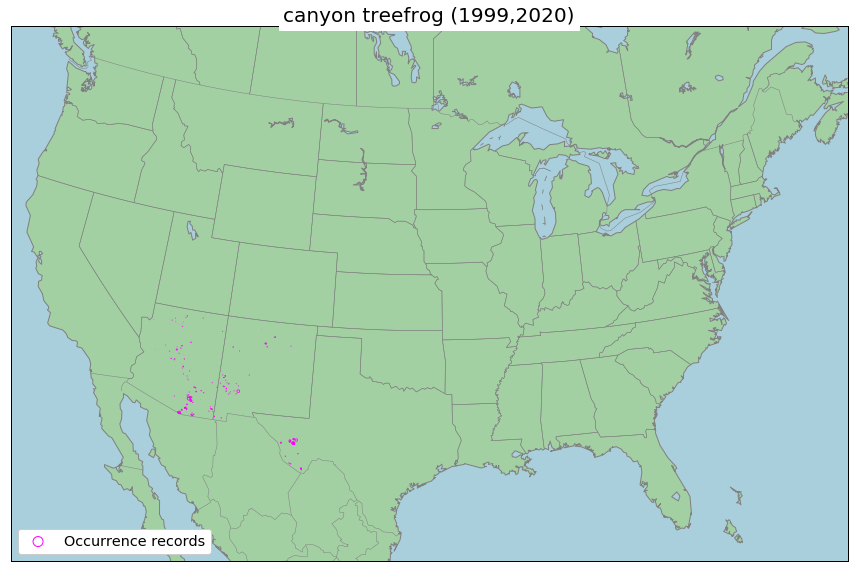

In [18]:
shp1 = {'file': '{0}{1}_polygons'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'magenta',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
map_these=[shp1]
    
title="{1} ({0})".format(years, common_name)
try:
    functions.MapShapefilePolygons(map_these=map_these, title=title)
except Exception as e:
    print("Unable to map:  " + str(e))

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

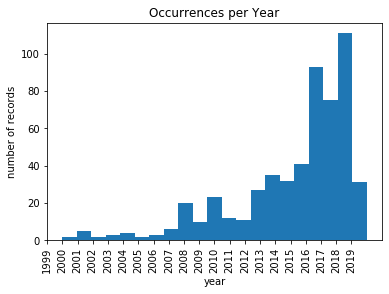

In [19]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

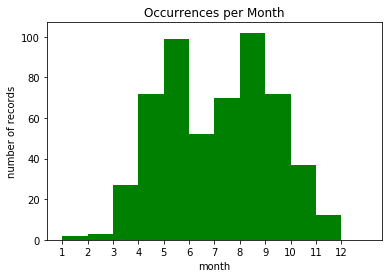

In [20]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

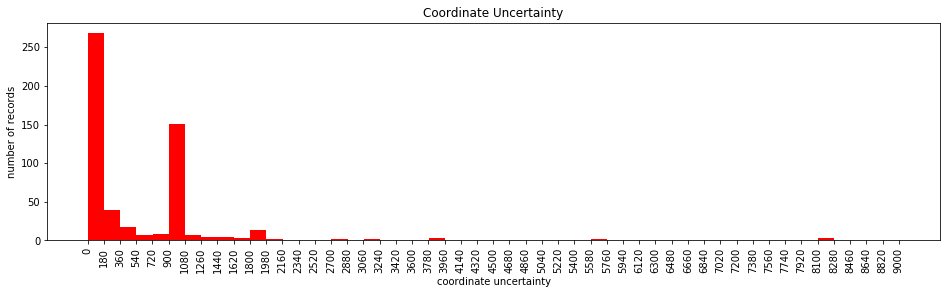

In [21]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty - Zoomed In')

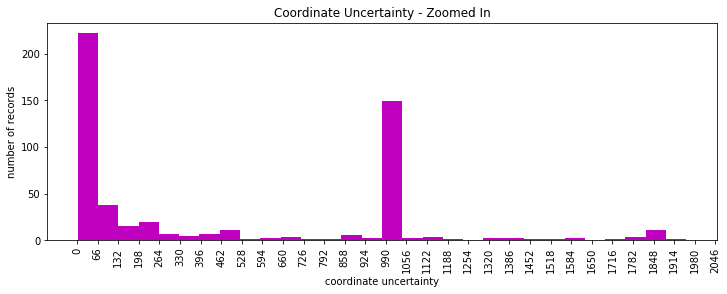

In [22]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty - Zoomed In")

### Establishment means reported

In [23]:
establishment = curs_occ.execute("SELECT vals FROM unique_values WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

UNKNOWN, NATIVE


### Identification qualifiers included

In [24]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM unique_values WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

UNKNOWN, A


### Remarks included

In [25]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Attributes returned for the records in the request (pre-filters)

In [26]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ)#, index_col='index')
fields_summary.index.name = 'Field'
pd.set_option('display.max_rows', 250)
print(fields_summary)

                                  attribute  included(n)  populated(n)
Field                                                                 
0                    acceptedScientificName          688           688
1                          acceptedTaxonKey          688           688
2                              accessRights           59            59
3                      associatedReferences            2             2
4                             basisOfRecord          688           688
5                     bibliographicCitation            5             5
6                             catalogNumber          688           688
7                                     class          688           688
8                                  classKey          688           688
9                            collectionCode          688           688
10                             collectionID           57            57
11                                continent           61            61
12    

### Runtime

In [27]:
t2 = datetime.now()
print(t2 - t1)

0:00:32.260463
